In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import imutils
import cv2
import keras
import time
%matplotlib inline

In [2]:
def process_img(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY)[1]
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9,9))
    dilate = cv2.morphologyEx(thresh, cv2.MORPH_DILATE, kernel)
    diff = cv2.absdiff(dilate, thresh)
    return diff

In [3]:
def background_identification1(frame,accumulated_weight):
    global background1
    if background1 is None:
        background1 = frame.copy().astype('float')
        return None
    
    cv2.accumulateWeighted(frame,background1,accumulated_weight1)

In [4]:
greenLower = np.array([25, 52, 72])
greenUpper = np.array([102, 255, 255])
ty=0
def segment(frame,background,threshold_min = 200):
    hsv=cv2.cvtColor(frame,cv2.COLOR_BGR2HSV)
    my_mask = cv2.inRange(hsv, greenLower,greenUpper) 
    diff=my_mask
    ret,thresholded = cv2.threshold(diff,threshold_min,255,cv2.THRESH_BINARY)
    kernel = np.ones((3,3),np.uint8)
    thresholded = cv2.morphologyEx(thresholded,cv2.MORPH_CLOSE,kernel)
    
    contours,hierarchy = cv2.findContours(thresholded.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        return None
    else:
        hand_segment = max(contours,key=cv2.contourArea)

        cnt=contours[0]
        (x,y),radius = cv2.minEnclosingCircle(cnt)
        center = (int(x),int(y))
        radius = int(radius)
        return (thresholded,hand_segment,center)

In [5]:
feature_params = dict( 
                       qualityLevel = 0.2,
                       minDistance = 7,
                       blockSize = 7 )
  
# Parameters for lucas kanade optical flow
lk_params = dict( winSize = (15, 15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT,10, 0.03))

Preparing the camera, gng to capture...
3
2
1
Capturing
Capturing done , saved image successfully
Now identifying the letter


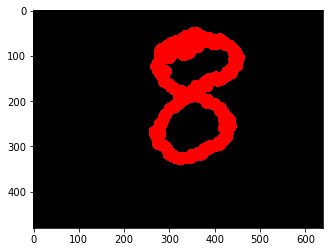

In [38]:
num_frames=0
background1 = None
accumulated_weight1 = 0.5
cap = cv2.VideoCapture(0)


print("Preparing the camera, gng to capture...")
time.sleep(1)
print(3)
time.sleep(1)
print(2)
time.sleep(1)
print(1)
print('Capturing')
time.sleep(1)
ret, old_frame = cap.read()
old_frame=cv2.flip(old_frame,1)
old_gray,s1,s2 = segment(old_frame,background1)
cv2.namedWindow('Face')
gauss=cv2.GaussianBlur(old_gray,(5,5),cv2.BORDER_DEFAULT)

p0 = cv2.goodFeaturesToTrack(gauss,1, mask = None,
                             **feature_params)
mask = np.zeros_like(old_frame)

kernel = np.ones((3,3),np.uint8)

canva=np.zeros((480,640))
while True:
    ret,frame = cap.read()
    frame_copy = frame.copy()
    frame_copy=cv2.flip(frame_copy,1)
    
    hand = segment(frame_copy,background1)
    
    
    
    if hand is not None:
        thresholded , hand_segment,center = hand
        gauss1=cv2.GaussianBlur(thresholded,(5,5),cv2.BORDER_DEFAULT)
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray,
                                           gauss1,
                                           p0, None,
                                           **lk_params)
  
        # Select good points
        if p1 is None or p0 is None:
            print('Capturing done , saved image successfully')
            print('Now identifying the letter')
            numm_img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            numm_img = cv2.erode(numm_img, kernel)
            cv2.imwrite('text.jpg',numm_img)
            kernel = np.ones((5, 5), np.uint8)
  
            # Using cv2.erode() method 
            
            plt.imshow(numm_img)
            break
            
        else:
            good_new = p1[st == 1]
            good_old = p0[st == 1]

            # draw the tracks
            for i, (new, old) in enumerate(zip(good_new, 
                                               good_old)):
                a, b = new.ravel()
                c, d = old.ravel()
                a=int(a)
                b=int(b)
                c=int(c)
                d=int(d)
                mask = cv2.line(mask, (a, b), (c, d),
                                (0,0,255), 2)

                full_frame = cv2.circle(mask, (a, b), 15,
                                   (0,0,255), -1)

                img = cv2.add(full_frame, mask)
            cv2.imshow('frame', img)

    #         cv2.imshow('Finger Count',frame_copy)

    #         if num_frames<60:
    #             corners = cv2.goodFeaturesToTrack(thresholded,1,0.01,10)

            corners = cv2.goodFeaturesToTrack(thresholded,1,0.01,10)
            cv2.imshow('Face',frame_copy)
           
            
    num_frames+=1
    if cv2.waitKey(1)&0xff==ord('q'):
        break
    old_gray = thresholded.copy()
    p0 = good_new.reshape(-1, 1, 2)
        
cap.release()
cv2.destroyAllWindows()

In [39]:
# pwd

In [40]:
model = keras.models.load_model('MNIST_keras_CNN.h5')

In [41]:
img = cv2.imread('text.jpg')
img_copy = img.copy()
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (400,440))

In [42]:
img_gray = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
_, img_thresh = cv2.threshold(img_gray, 10, 255, cv2.THRESH_BINARY_INV)
img_final = cv2.resize(img_thresh, (28,28),cv2.INTER_NEAREST)
img_fin =np.reshape(img_final, (1,28,28,1))

In [43]:
print("The number I predicted is  ", np.argmax(model.predict(img_fin)))

The number I predicted is   8


In [44]:
cv2.namedWindow('predicted letter')
canvas=np.zeros((480,640,3))
cv2.putText(canvas, str(np.argmax(model.predict(img_fin)))+" was written", (50,200), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 2, cv2.LINE_AA)

while True:
    cv2.imshow('predicted letter',canvas)
    if cv2.waitKey(1)&0xff==ord('q'):
        break
cv2.destroyAllWindows()

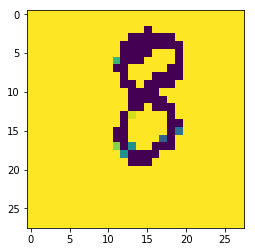

In [45]:
plt.imshow(img_final)